In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    
    temp['NET'] = 37-(37-temp['T'])/(0.68-0.0014*temp.RH+1/(1.76+1.4*temp.WS**0.75))-0.29*temp['T']*(1-0.001*temp.RH)
    
    temp = temp[['Day','Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T', 'NET']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Day','Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T', 'NET']]
                              
        return temp.iloc[-48:, :]

In [32]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    
    #temp['NET'] = 37-(37-temp['T'])/(0.68-0.0014*temp.RH+1/(1.76+1.4*temp.WS**0.75))-0.29*temp['T']*(1-0.001*temp.RH)
    
    temp = temp[['Day','Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Day','Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

In [33]:
train = pd.read_csv('./data/train/train.csv')

test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp['Day'] = i
    temp = preprocess_data(temp, is_train=False)
    test.append(temp)

df_test = pd.concat(test)

submission = pd.read_csv('./data/sample_submission.csv')

In [34]:
df_train = preprocess_data(train)

df_train.shape, df_test.shape

((52464, 10), (3888, 8))

In [35]:
df_train.WS = np.log1p(df_train.WS)
df_test.WS = np.log1p(df_test.WS)

In [6]:
min = df_train[['Day','Hour','DHI','DNI','WS','RH','T','NET']].min()
max  = df_train[['Day','Hour','DHI','DNI','WS','RH','T','NET']].max()

for i, col in enumerate(['Day','Hour','DHI','DNI','WS','RH','T','NET']):
    df_train[col] = (df_train[col] - min[i]) / (max[i] - min[i])
    df_test[col] = (df_test[col] - min[i]) / (max[i] - min[i])

In [36]:
min = df_train[['Day','Hour','DHI','DNI','WS','RH','T']].min()
max  = df_train[['Day','Hour','DHI','DNI','WS','RH','T']].max()

for i, col in enumerate(['Day','Hour','DHI','DNI','WS','RH','T']):
    df_train[col] = (df_train[col] - min[i]) / (max[i] - min[i])
    df_test[col] = (df_test[col] - min[i]) / (max[i] - min[i])

In [37]:
Day0 = df_train.iloc[:, :-2]
Day  = df_train.iloc[:, 1:-2]
Day7 = df_train.iloc[:, -2]
Day8 = df_train.iloc[:, -1]
Day78 = df_train.iloc[:, -2:]

df_test0 = df_test.copy()
df_test = df_test.iloc[:, 1:]

In [12]:
def quantile_loss(q, y, pred):
    err = (y-pred)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [13]:
q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(Day, Day78, test_size=0.25, random_state=42)

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(Day, Day7, test_size=0.25, random_state=42)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(Day, Day8, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((39348, 7), (13116, 7), (39348, 2), (13116, 2))

In [15]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import mean, maximum

tf.random.set_seed(42)

epoch = 100

In [44]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(Day.shape)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train, Y_train, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
model.evaluate(X_valid, Y_valid)

Epoch 1/100
615/615 [==============================] - 1s 1ms/step - loss: 385.0964 - val_loss: 176.8785
Epoch 2/100
615/615 [==============================] - 1s 1ms/step - loss: 169.5682 - val_loss: 158.1537
Epoch 3/100
615/615 [==============================] - 1s 1ms/step - loss: 153.5013 - val_loss: 151.6759
Epoch 4/100
615/615 [==============================] - 1s 1ms/step - loss: 154.4273 - val_loss: 149.5001
Epoch 5/100
615/615 [==============================] - 1s 1ms/step - loss: 148.2966 - val_loss: 150.2883
Epoch 6/100
615/615 [==============================] - 1s 1ms/step - loss: 149.8032 - val_loss: 151.9733
Epoch 7/100
615/615 [==============================] - 1s 1ms/step - loss: 149.0454 - val_loss: 144.9851
Epoch 8/100
615/615 [==============================] - 1s 1ms/step - loss: 141.6659 - val_loss: 149.7142
Epoch 9/100
615/615 [==============================] - 1s 1ms/step - loss: 147.3332 - val_loss: 145.1392
Epoch 10/100
615/615 [==============================] -

137.20550537109375

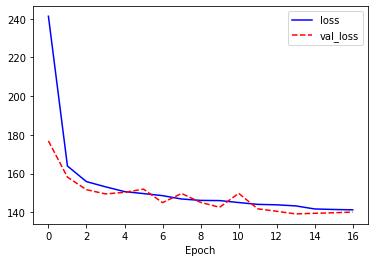

In [45]:
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [46]:
# -NET
results = pd.DataFrame()

for q in q_lst:
    model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model.fit(Day, Day78, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred = pd.DataFrame(model.predict(df_test))
    results = pd.concat([results, pred], axis=1)

results.shape

Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 1.4851 - val_loss: 1.6052
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4185 - val_loss: 1.6069
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4072 - val_loss: 1.6011
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4009 - val_loss: 1.5986
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4115 - val_loss: 1.6163
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4009 - val_loss: 1.6200
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4136 - val_loss: 1.6082
Epoch 00007: early stopping
Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 2.2932 - val_loss: 2.6119
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2651 - val_loss: 2.6073
Epoch 3/100
820/820 [==============================] - 1s 1ms/s

820/820 [==============================] - 2s 1ms/step - loss: 2.6751 - val_loss: 2.9923
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6447 - val_loss: 3.0326
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6520 - val_loss: 3.0277
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6457 - val_loss: 3.0934
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 2.3706 - val_loss: 2.6839
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3444 - val_loss: 2.6989
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3495 - val_loss: 2.6958
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3539 - val_loss: 2.7136
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 1.9412 - val_loss: 2.1818
Epoch 2/100
820/820 [==========================

Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7849 - val_loss: 0.9720
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7940 - val_loss: 0.9880
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7872 - val_loss: 0.8869
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7812 - val_loss: 0.8837
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7770 - val_loss: 0.8834
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7907 - val_loss: 0.8926
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 0.8064 - val_loss: 0.9210
Epoch 9/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7766 - val_loss: 0.9302
Epoch 00009: early stopping


(3888, 18)

In [48]:
results[0][:48]

,0,0,0,0,0,0,0,0,0
0,-0.173280,-0.112882,-0.026336,-0.082966,-0.142874,-0.158126,0.035049,0.105459,0.098779
1,-0.175137,-0.114583,-0.027262,-0.085657,-0.144745,-0.161045,0.033186,0.103376,0.100205
2,-0.168723,-0.115475,-0.043168,-0.092992,-0.152000,-0.166081,0.034788,0.094770,0.093328
3,-0.167419,-0.114649,-0.042480,-0.090919,-0.149597,-0.164335,0.035445,0.096288,0.091852
4,-0.140366,-0.113283,-0.057419,-0.094727,-0.151547,-0.167499,0.034782,0.090059,0.083736
5,-0.143237,-0.116482,-0.058976,-0.096986,-0.157438,-0.174194,0.032678,0.086638,0.086372
6,-0.136401,-0.117417,-0.075423,-0.106786,-0.162762,-0.183641,0.028700,0.082952,0.079357
7,-0.143101,-0.121938,-0.078156,-0.110703,-0.172558,-0.189191,0.021167,0.074970,0.086059
8,-0.141119,-0.119701,-0.093900,-0.123412,-0.180591,-0.188250,0.023280,0.062130,0.078949
9,-0.146155,-0.122809,-0.091415,-0.126262,-0.186476,-0.188260,0.028133,0.063044,0.078893


In [47]:
results[1][:48]

,1,1,1,1,1,1,1,1,1
0,-0.196271,-0.074919,-0.056662,-0.061915,-0.116000,-0.119493,0.061687,0.089609,0.069562
1,-0.198651,-0.076534,-0.058552,-0.064448,-0.118259,-0.122723,0.059422,0.087269,0.069196
2,-0.202375,-0.086865,-0.072739,-0.064942,-0.117579,-0.122366,0.062973,0.080645,0.059048
3,-0.200499,-0.086200,-0.071209,-0.062759,-0.115310,-0.120421,0.063775,0.082415,0.058865
4,-0.202891,-0.094238,-0.083316,-0.059101,-0.108575,-0.117404,0.062292,0.069193,0.049584
5,-0.206415,-0.097278,-0.086791,-0.062549,-0.113868,-0.124359,0.060374,0.067520,0.048884
6,-0.208896,-0.107616,-0.100869,-0.060932,-0.110093,-0.128710,0.056342,0.064198,0.038742
7,-0.218464,-0.111346,-0.107530,-0.062085,-0.117532,-0.130268,0.049430,0.059209,0.038563
8,-0.228049,-0.113947,-0.118512,-0.062370,-0.113471,-0.121565,0.054826,0.045247,0.024571
9,-0.234109,-0.115230,-0.115352,-0.064615,-0.117477,-0.118512,0.061561,0.045332,0.021873


In [20]:
from lightgbm import LGBMRegressor

In [49]:
# -NET
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in q_lst:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=q_lst
    
    return LGBM_models, LGBM_actual_pred

models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, df_test)
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, df_test)

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.34889
Early stopping, best iteration is:
[418]	valid_0's quantile: 1.34812
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.14466
[1000]	valid_0's quantile: 2.13764
[1500]	valid_0's quantile: 2.13582
[2000]	valid_0's quantile: 2.1334
Early stopping, best iteration is:
[1749]	valid_0's quantile: 2.13312
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.53565
[1000]	valid_0's quantile: 2.50726
[1500]	valid_0's quantile: 2.49216
Early stopping, best iteration is:
[1604]	valid_0's quantile: 2.48959
0.4
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.66191
[1000]	valid_0's quantile: 2.62846
[1500]	valid_0's quantile: 2.61266
[2000]	valid_0's quantile: 2.6059
[2500]	valid_0's quantile: 2.59923
[3000]	valid_0's quantile: 2.59644
Early stopping, best iteration is:
[2707]	v

In [50]:
results_1[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [51]:
results_2[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [25]:
# + NET
model7 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model7.fit(np.array(Day).reshape(52464, 1, 8), np.array(Day7).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred7 = np.squeeze(model7.predict(np.array(df_test).reshape(3888, 1, 8)))
    pred7 = pd.DataFrame(pred7)
    result7 = pd.concat([result7, pred7], axis=1)
    
result7[:48]

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4362 - val_loss: 1.6001
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4215 - val_loss: 1.5991
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4143 - val_loss: 1.5978
Epoch 4/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4161 - val_loss: 1.5971
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4239 - val_loss: 1.6024
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4159 - val_loss: 1.6165
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4175 - val_loss: 1.6275
Epoch 8/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4330 - val_loss: 1.5965
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4209 - val_loss: 1.5990
Epoch 10/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4345 - va

820/820 [==============================] - 2s 2ms/step - loss: 2.2838 - val_loss: 2.6047
Epoch 00006: early stopping
0.7
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.8741 - val_loss: 2.1431
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 1.8510 - val_loss: 2.1834
Epoch 3/100
820/820 [==============================] - 1s 2ms/step - loss: 1.8588 - val_loss: 2.1971
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 1.8568 - val_loss: 2.1538
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 1.8524 - val_loss: 2.1844
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 1.8717 - val_loss: 2.1307
Epoch 7/100
820/820 [==============================] - 1s 2ms/step - loss: 1.8831 - val_loss: 2.1272
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 1.9120 - val_loss: 2.1280
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - lo

,0,0,0,0,0,0,0,0,0
0,0.000981,-0.001112,-0.003431,0.001779,0.000407,-0.000764,0.000766,0.007204,0.009807
1,0.000987,-0.001112,-0.003427,0.001779,0.000406,-0.000765,0.000766,0.007228,0.009963
2,0.001030,-0.001076,-0.003394,0.001791,0.000415,-0.000702,0.000758,0.007079,0.009766
3,0.001021,-0.001075,-0.003396,0.001790,0.000415,-0.000704,0.000758,0.007068,0.009648
4,0.001060,-0.001047,-0.003368,0.001801,0.000424,-0.000637,0.000749,0.006880,0.009285
5,0.001070,-0.001047,-0.003364,0.001802,0.000422,-0.000637,0.000749,0.006928,0.009577
6,0.001092,-0.001034,-0.003370,0.001812,0.000426,-0.000590,0.000741,0.006778,0.009381
7,0.001129,-0.001039,-0.003381,0.001812,0.000416,-0.000596,0.000741,0.006861,0.009999
8,0.001150,-0.001033,-0.003411,0.001813,0.000396,-0.000578,0.000735,0.006851,0.010179
9,0.001160,-0.001034,-0.003422,0.001813,0.000374,-0.000616,0.000737,0.007040,0.010612


In [26]:
model8 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model8.fit(np.array(Day).reshape(52464, 1, 8), np.array(Day8).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred8 = np.squeeze(model8.predict(np.array(df_test).reshape(3888, 1, 8)))
    pred8 = pd.DataFrame(pred8)
    result8 = pd.concat([result8, pred8], axis=1)
    
result8[:48]

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4553 - val_loss: 1.6462
Epoch 2/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4443 - val_loss: 1.6418
Epoch 3/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4341 - val_loss: 1.6406
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4258 - val_loss: 1.6402
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4430 - val_loss: 1.6403
Epoch 6/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4354 - val_loss: 1.6465
Epoch 7/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4442 - val_loss: 1.6470
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4518 - val_loss: 1.6387
Epoch 9/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4510 - val_loss: 1.6402
Epoch 10/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4608 - va

820/820 [==============================] - 1s 2ms/step - loss: 2.7233 - val_loss: 3.0800
Epoch 3/100
820/820 [==============================] - 1s 2ms/step - loss: 2.7260 - val_loss: 3.0978
Epoch 4/100
820/820 [==============================] - 1s 2ms/step - loss: 2.7274 - val_loss: 3.1748
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 2.7421 - val_loss: 3.1169
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 2.6985 - val_loss: 3.0875
Epoch 00006: early stopping
0.6
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 2.4140 - val_loss: 2.7751
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 2.4128 - val_loss: 2.7858
Epoch 3/100
820/820 [==============================] - 1s 2ms/step - loss: 2.4055 - val_loss: 2.7868
Epoch 4/100
820/820 [==============================] - 1s 2ms/step - loss: 2.4099 - val_loss: 2.8709
Epoch 5/100
820/820 [==============================] - 2s 2ms/step - lo

,0,0,0,0,0,0,0,0,0
0,0.000177,-0.005943,-0.002400,-0.001468,0.000945,0.000029,-0.001986,0.005396,0.013456
1,0.000177,-0.005943,-0.002400,-0.001468,0.000945,0.000029,-0.001986,0.005396,0.013456
2,0.000177,-0.005943,-0.002400,-0.001468,0.000945,0.000029,-0.001986,0.005396,0.013456
3,0.000177,-0.005943,-0.002400,-0.001468,0.000945,0.000029,-0.001986,0.005396,0.013456
4,0.000177,-0.005943,-0.002400,-0.001468,0.000945,0.000029,-0.001986,0.005396,0.013456
5,0.000177,-0.005943,-0.002400,-0.001468,0.000945,0.000029,-0.001986,0.005396,0.013456
6,0.000177,-0.005943,-0.002400,-0.001468,0.000945,0.000029,-0.001986,0.005396,0.013456
7,0.000177,-0.005943,-0.002400,-0.001468,0.000945,0.000029,-0.001986,0.005396,0.013456
8,0.000177,-0.005943,-0.002400,-0.001468,0.000945,0.000029,-0.001986,0.005396,0.013456
9,0.000177,-0.005943,-0.002400,-0.001468,0.000945,0.000029,-0.001986,0.005396,0.013456


In [ ]:
model = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[39348, 8]),
    layers.GRU(units=32),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X_train_1).reshape(39348, 1, 8), np.array(Y_train_1).reshape(39348, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
pred = np.squeeze(model8.predict(np.array(X_valid_1).reshape(13116, 1, 8)))

In [27]:
# +NET
model_G7 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 8]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G7.fit(np.array(Day).reshape(52464, 1, 8), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G7 = np.squeeze(model_G7.predict(np.array(df_test).reshape(3888, 1, 8)))
    pred_G7 = pd.DataFrame(pred_G7)
    result_G7 = pd.concat([result_G7, pred_G7], axis=1)
    
result_G7[:48]

0.1
Epoch 1/100
820/820 [==============================] - 5s 3ms/step - loss: 1.5208 - val_loss: 1.6270
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4344 - val_loss: 1.6103
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4214 - val_loss: 1.6054
Epoch 4/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4114 - val_loss: 1.5974
Epoch 5/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4156 - val_loss: 1.5884
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4008 - val_loss: 1.6034
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4022 - val_loss: 1.5911
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4172 - val_loss: 1.5799
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3998 - val_loss: 1.5808
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4212 - va

0.3
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.6305 - val_loss: 2.9986
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6031 - val_loss: 2.9877
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5995 - val_loss: 2.9991
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5707 - val_loss: 2.9971
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6129 - val_loss: 2.9779
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6055 - val_loss: 3.0341
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6078 - val_loss: 2.9769
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6413 - val_loss: 2.9844
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5880 - val_loss: 2.9757
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6480 - va

820/820 [==============================] - 3s 3ms/step - loss: 2.5356 - val_loss: 2.9029
Epoch 15/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5443 - val_loss: 2.9037
Epoch 16/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5253 - val_loss: 2.9002
Epoch 17/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5594 - val_loss: 2.9160
Epoch 00017: early stopping
0.6
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.2829 - val_loss: 2.6288
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2534 - val_loss: 2.6022
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2569 - val_loss: 2.6000
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2452 - val_loss: 2.6415
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2586 - val_loss: 2.6187
Epoch 6/100
820/820 [==============================] - 3s 3ms/step -

820/820 [==============================] - 6s 4ms/step - loss: 0.7579 - val_loss: 0.8550
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7437 - val_loss: 0.8649
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7505 - val_loss: 0.8536
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7472 - val_loss: 0.8764
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7449 - val_loss: 0.8749
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7519 - val_loss: 0.8692
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 0.7575 - val_loss: 0.8570
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 0.7598 - val_loss: 0.8570
Epoch 00008: early stopping


,0,0,0,0,0,0,0,0,0
0,0.004687,-0.004363,0.005436,-0.001327,0.002000,0.000578,0.000604,0.001120,0.008211
1,0.005000,-0.004383,0.005192,-0.001109,0.002059,0.001268,0.000633,0.001313,0.008475
2,0.004861,-0.005005,0.004361,0.000297,0.000408,-0.000454,-0.000469,0.001341,0.008420
3,0.004595,-0.004791,0.004693,0.000259,0.000636,-0.000532,-0.000228,0.001228,0.008217
4,0.004322,-0.005377,0.004034,0.001073,-0.000515,-0.002515,-0.001196,0.001387,0.008652
5,0.004676,-0.005581,0.003488,0.001255,-0.000746,-0.001925,-0.001427,0.001871,0.009237
6,0.004451,-0.006127,0.002628,0.001916,-0.001293,-0.003043,-0.002360,0.002682,0.010883
7,0.004600,-0.007874,0.000706,0.002031,-0.001656,-0.002441,-0.003437,0.003469,0.012211
8,0.003826,-0.010022,-0.001114,0.002588,-0.001600,-0.001245,-0.004002,0.004862,0.015793
9,0.003711,-0.011384,-0.002156,0.002659,-0.001726,-0.000128,-0.004375,0.005038,0.016471


In [28]:
model_G8 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 8]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G8.fit(np.array(Day).reshape(52464, 1, 8), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G8 = np.squeeze(model_G8.predict(np.array(df_test).reshape(3888, 1, 8)))
    pred_G8 = pd.DataFrame(pred_G8)
    result_G8 = pd.concat([result_G8, pred_G8], axis=1)
    
result_G8[:48]

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5275 - val_loss: 1.6281
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4352 - val_loss: 1.6098
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4217 - val_loss: 1.6018
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4105 - val_loss: 1.5957
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4160 - val_loss: 1.5894
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4016 - val_loss: 1.6057
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4030 - val_loss: 1.5896
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4185 - val_loss: 1.5791
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4016 - val_loss: 1.5785
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4223 - va

Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6125 - val_loss: 2.9899
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6091 - val_loss: 2.9900
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5841 - val_loss: 2.9926
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6238 - val_loss: 2.9787
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6116 - val_loss: 3.0118
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6184 - val_loss: 2.9843
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6497 - val_loss: 2.9888
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5958 - val_loss: 2.9765
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6585 - val_loss: 2.9735
Epoch 11/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5494 - val_l

820/820 [==============================] - 3s 3ms/step - loss: 2.6042 - val_loss: 2.9108
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5335 - val_loss: 2.9502
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5947 - val_loss: 2.8943
Epoch 11/100
820/820 [==============================] - 3s 3ms/step - loss: 2.4849 - val_loss: 2.9194
Epoch 12/100
820/820 [==============================] - 3s 3ms/step - loss: 2.4961 - val_loss: 2.8865
Epoch 13/100
820/820 [==============================] - 3s 4ms/step - loss: 2.5315 - val_loss: 2.9637
Epoch 14/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5241 - val_loss: 2.9061
Epoch 15/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5291 - val_loss: 2.8907
Epoch 16/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5185 - val_loss: 2.8982
Epoch 17/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5420 - val_loss: 2

820/820 [==============================] - 6s 4ms/step - loss: 1.3529 - val_loss: 1.5451
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3186 - val_loss: 1.5690
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3386 - val_loss: 1.5711
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3308 - val_loss: 1.5979
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3292 - val_loss: 1.5711
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3433 - val_loss: 1.5586
Epoch 00006: early stopping
0.9
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.7508 - val_loss: 0.8625
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7377 - val_loss: 0.8706
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7466 - val_loss: 0.8528
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - lo

,0,0,0,0,0,0,0,0,0
0,0.001016,-0.000389,0.002657,0.007510,0.000228,-0.002918,-0.003773,0.005013,0.005168
1,0.001304,-0.000423,0.002826,0.007772,0.000905,-0.002319,-0.003451,0.005149,0.005025
2,0.001727,-0.000029,0.001942,0.003326,-0.000123,-0.001520,-0.001634,0.003704,0.003990
3,0.001506,0.000084,0.001775,0.003025,-0.000451,-0.001742,-0.001864,0.003543,0.003994
4,0.001630,0.000416,0.000709,0.002038,-0.000606,-0.002111,-0.000677,0.002234,0.004420
5,0.002042,0.000231,0.000983,0.002631,-0.000164,-0.001571,0.000109,0.002712,0.004595
6,0.002250,0.000381,-0.000027,0.003555,0.000431,-0.002713,0.001590,0.002497,0.007543
7,0.002652,-0.000535,0.000378,0.004027,0.000429,-0.002913,0.002743,0.002721,0.007584
8,0.002606,-0.001188,-0.000373,0.003354,-0.000232,-0.005337,0.004918,0.001468,0.010557
9,0.002697,-0.001649,-0.000315,0.002830,-0.000910,-0.006365,0.005653,0.001312,0.011016


In [29]:
# +NET

model_M7 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 9]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M7.fit(np.array(Day0).reshape(52464, 1, 9), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M7 = np.squeeze(model_M7.predict(np.array(df_test0).reshape(3888, 1, 9)))
    pred_M7 = pd.DataFrame(pred_M7)
    result_M7 = pd.concat([result_M7, pred_M7], axis=1)
    
result_M7[:48]

0.1
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 1.5512 - val_loss: 1.6329
Epoch 2/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4394 - val_loss: 1.6113
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4198 - val_loss: 1.6146
Epoch 4/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4062 - val_loss: 1.6264
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4108 - val_loss: 1.5832
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3948 - val_loss: 1.6424
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3948 - val_loss: 1.6169
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4110 - val_loss: 1.6025
Epoch 00008: early stopping
0.2
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.3308 - val_loss: 2.6054
Epoch 2/100
820/820 [==============================] - 

0.5
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 2.6916 - val_loss: 3.0115
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6513 - val_loss: 2.9731
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 2.6387 - val_loss: 2.9769
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6425 - val_loss: 2.9933
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6620 - val_loss: 2.9949
Epoch 00005: early stopping
0.6
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.4304 - val_loss: 2.7259
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3988 - val_loss: 2.6921
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3855 - val_loss: 2.7057
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3849 - val_loss: 2.7324
Epoch 5/100
820/820 [==============================] - 

820/820 [==============================] - 5s 4ms/step - loss: 0.8505 - val_loss: 0.9536
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8302 - val_loss: 0.9688
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8415 - val_loss: 0.9495
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8337 - val_loss: 0.9575
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8427 - val_loss: 0.9806
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8336 - val_loss: 0.9380
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8434 - val_loss: 0.9370
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8438 - val_loss: 0.9401
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8177 - val_loss: 0.9631
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8388 - val_loss: 0.9935
E

,0,0,0,0,0,0,0,0,0
0,-0.025156,-0.013253,-0.002063,-0.010397,-0.009584,0.011747,0.023365,0.010626,0.061637
1,-0.025134,-0.013022,-0.002140,-0.010277,-0.009148,0.011234,0.023427,0.010931,0.060183
2,-0.024511,-0.012978,-0.002520,-0.011473,-0.011140,0.005508,0.012225,0.001916,0.058211
3,-0.024558,-0.013143,-0.002306,-0.011226,-0.011087,0.006331,0.012539,0.001968,0.059596
4,-0.023976,-0.013308,-0.002698,-0.012568,-0.013493,0.001924,0.002373,-0.006729,0.058327
5,-0.023961,-0.012929,-0.002689,-0.012271,-0.012604,0.001386,0.002988,-0.005386,0.057103
6,-0.023437,-0.012877,-0.002717,-0.012813,-0.013736,-0.001402,-0.004479,-0.011112,0.056343
7,-0.023514,-0.011895,-0.002166,-0.012304,-0.012060,-0.003623,-0.004381,-0.008891,0.055771
8,-0.023176,-0.011118,-0.000895,-0.011551,-0.011026,-0.005771,-0.009467,-0.010279,0.059837
9,-0.023502,-0.010486,-0.000027,-0.010635,-0.009500,-0.006829,-0.009509,-0.009076,0.060506


In [30]:
model_M8 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 9]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M8.fit(np.array(Day0).reshape(52464, 1, 9), np.array(Day8).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M8 = np.squeeze(model_M8.predict(np.array(df_test0).reshape(3888, 1, 9)))
    pred_M8 = pd.DataFrame(pred_M8)
    result_M8 = pd.concat([result_M8, pred_M8], axis=1)
    
result_M8[:48]

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5622 - val_loss: 1.6496
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4543 - val_loss: 1.6489
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4303 - val_loss: 1.6523
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4176 - val_loss: 1.6257
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4274 - val_loss: 1.6347
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4148 - val_loss: 1.6385
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4237 - val_loss: 1.6590
Epoch 00007: early stopping
0.2
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.4309 - val_loss: 2.7301
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3799 - val_loss: 2.7068
Epoch 3/100
820/820 [==============================] - 

820/820 [==============================] - 3s 3ms/step - loss: 2.9484 - val_loss: 3.3142
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.9344 - val_loss: 3.2937
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.9375 - val_loss: 3.3274
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.9290 - val_loss: 3.3090
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.9126 - val_loss: 3.2943
Epoch 00006: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.8793 - val_loss: 3.2226
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.8425 - val_loss: 3.1930
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.8309 - val_loss: 3.1994
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.8295 - val_loss: 3.1871
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - lo

820/820 [==============================] - 3s 3ms/step - loss: 2.0066 - val_loss: 2.3089
Epoch 24/100
820/820 [==============================] - 3s 3ms/step - loss: 2.0339 - val_loss: 2.3437
Epoch 00024: early stopping
0.8
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 1.4834 - val_loss: 1.6419
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4674 - val_loss: 1.6700
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4638 - val_loss: 1.7555
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4697 - val_loss: 1.6418
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4609 - val_loss: 1.6783
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4371 - val_loss: 1.6343
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4701 - val_loss: 1.6498
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - l

,0,0,0,0,0,0,0,0,0
0,-0.008475,-0.003593,-0.010970,-0.009766,-0.001435,0.009317,0.007745,-0.001998,0.013644
1,-0.008172,-0.002848,-0.011345,-0.008944,-0.001234,0.009965,0.008533,-0.001692,0.013986
2,-0.007855,-0.002624,-0.011701,-0.007621,0.000501,0.008573,0.007745,0.001441,0.018128
3,-0.008168,-0.003216,-0.011477,-0.008326,0.000420,0.007978,0.007057,0.001221,0.017873
4,-0.008183,-0.003836,-0.011515,-0.008049,0.002103,0.006263,0.001220,0.000509,0.020448
5,-0.007627,-0.002345,-0.011969,-0.006306,0.002835,0.007906,0.002986,0.000615,0.020618
6,-0.007451,-0.002027,-0.012095,-0.004981,0.005641,0.007945,-0.003716,-0.004533,0.022629
7,-0.006254,0.000044,-0.013250,-0.001024,0.006912,0.011593,-0.000667,-0.004474,0.023953
8,-0.005532,0.000878,-0.014068,0.002965,0.010953,0.014594,-0.005948,-0.011721,0.032198
9,-0.005155,0.000487,-0.015745,0.004819,0.011386,0.015880,-0.004026,-0.010507,0.036050


In [52]:
res_L0 = pd.DataFrame(results_1.sort_index())
res_L0.columns = ['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']
res_L1 = pd.DataFrame(results_2.sort_index())
res_L1.columns = ['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']

res_D0 = pd.DataFrame(results[0].sort_index())
res_D0.columns = ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9']
res_D1 = pd.DataFrame(results[1].sort_index())
res_D1.columns = ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9']

res_C0 = pd.DataFrame(result7.sort_index())
res_C0.columns = ['C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9']
res_C1 = pd.DataFrame(result8.sort_index())
res_C1.columns = ['C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9']

res_G0 = pd.DataFrame(result_G7.sort_index())
res_G0.columns = ['G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9']
res_G1 = pd.DataFrame(result_G8.sort_index())
res_G1.columns = ['G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9']

res_M0 = pd.DataFrame(result_M7.sort_index())
res_M0.columns = ['M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9']
res_M1 = pd.DataFrame(result_M8.sort_index())
res_M1.columns = ['M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9']

In [53]:
res_0 = pd.DataFrame()
res_1= pd.DataFrame()
res_0 = pd.concat([res_L0, res_D0, res_C0, res_G0, res_M0], axis=1)
res_1 = pd.concat([res_L1, res_D1, res_C1, res_G1, res_M1], axis=1)

In [54]:
res_0[:48]

,L00.1,L00.2,L00.3,L00.4,L00.5,L00.6,L00.7,L00.8,L00.9,D00.1,...,G00.9,M00.1,M00.2,M00.3,M00.4,M00.5,M00.6,M00.7,M00.8,M00.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.173280,...,0.008211,-0.025156,-0.013253,-0.002063,-0.010397,-0.009584,0.011747,0.023365,0.010626,0.061637
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.175137,...,0.008475,-0.025134,-0.013022,-0.002140,-0.010277,-0.009148,0.011234,0.023427,0.010931,0.060183
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.168723,...,0.008420,-0.024511,-0.012978,-0.002520,-0.011473,-0.011140,0.005508,0.012225,0.001916,0.058211
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.167419,...,0.008217,-0.024558,-0.013143,-0.002306,-0.011226,-0.011087,0.006331,0.012539,0.001968,0.059596
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.140366,...,0.008652,-0.023976,-0.013308,-0.002698,-0.012568,-0.013493,0.001924,0.002373,-0.006729,0.058327
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.143237,...,0.009237,-0.023961,-0.012929,-0.002689,-0.012271,-0.012604,0.001386,0.002988,-0.005386,0.057103
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.136401,...,0.010883,-0.023437,-0.012877,-0.002717,-0.012813,-0.013736,-0.001402,-0.004479,-0.011112,0.056343
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.143101,...,0.012211,-0.023514,-0.011895,-0.002166,-0.012304,-0.012060,-0.003623,-0.004381,-0.008891,0.055771
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.141119,...,0.015793,-0.023176,-0.011118,-0.000895,-0.011551,-0.011026,-0.005771,-0.009467,-0.010279,0.059837
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.146155,...,0.016471,-0.023502,-0.010486,-0.000027,-0.010635,-0.009500,-0.006829,-0.009509,-0.009076,0.060506


In [55]:
res_1[:48]

,L10.1,L10.2,L10.3,L10.4,L10.5,L10.6,L10.7,L10.8,L10.9,D10.1,...,G10.9,M10.1,M10.2,M10.3,M10.4,M10.5,M10.6,M10.7,M10.8,M10.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.196271,...,0.005168,-0.008475,-0.003593,-0.010970,-0.009766,-0.001435,0.009317,0.007745,-0.001998,0.013644
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.198651,...,0.005025,-0.008172,-0.002848,-0.011345,-0.008944,-0.001234,0.009965,0.008533,-0.001692,0.013986
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.202375,...,0.003990,-0.007855,-0.002624,-0.011701,-0.007621,0.000501,0.008573,0.007745,0.001441,0.018128
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.200499,...,0.003994,-0.008168,-0.003216,-0.011477,-0.008326,0.000420,0.007978,0.007057,0.001221,0.017873
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.202891,...,0.004420,-0.008183,-0.003836,-0.011515,-0.008049,0.002103,0.006263,0.001220,0.000509,0.020448
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.206415,...,0.004595,-0.007627,-0.002345,-0.011969,-0.006306,0.002835,0.007906,0.002986,0.000615,0.020618
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.208896,...,0.007543,-0.007451,-0.002027,-0.012095,-0.004981,0.005641,0.007945,-0.003716,-0.004533,0.022629
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.218464,...,0.007584,-0.006254,0.000044,-0.013250,-0.001024,0.006912,0.011593,-0.000667,-0.004474,0.023953
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.228049,...,0.010557,-0.005532,0.000878,-0.014068,0.002965,0.010953,0.014594,-0.005948,-0.011721,0.032198
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.234109,...,0.011016,-0.005155,0.000487,-0.015745,0.004819,0.011386,0.015880,-0.004026,-0.010507,0.036050


In [56]:
res_0.loc[res_0[res_0['L00.1'] == 0].index, ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9'
                                            ,'C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9'
                                            ,'G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9'
                                            ,'M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9'
                                            ]] = 0
res_1.loc[res_1[res_1['L10.1'] == 0].index, ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9'
                                            ,'C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9'
                                            ,'G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9'
                                            ,'M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9'
                                            ]] = 0

In [57]:
res_0[:48]#.to_csv('0.csv', index=False)

,L00.1,L00.2,L00.3,L00.4,L00.5,L00.6,L00.7,L00.8,L00.9,D00.1,...,G00.9,M00.1,M00.2,M00.3,M00.4,M00.5,M00.6,M00.7,M00.8,M00.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [58]:
res_1[:48]#.to_csv('0.csv', index=False)

,L10.1,L10.2,L10.3,L10.4,L10.5,L10.6,L10.7,L10.8,L10.9,D10.1,...,G10.9,M10.1,M10.2,M10.3,M10.4,M10.5,M10.6,M10.7,M10.8,M10.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [59]:
for i in range(1, 10):
    res_0["L00."+str(i)] = (res_0["L00."+str(i)] + res_0["D00."+str(i)] + res_0["C00."+str(i)] + res_0["G00."+str(i)] + res_0["M00."+str(i)])/5
    res_1["L10."+str(i)] = (res_1["L10."+str(i)] + res_1["D10."+str(i)] + res_1["C10."+str(i)] + res_1["G10."+str(i)] + res_1["M10."+str(i)])/5

In [60]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = res_0[['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']].values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = res_1[['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']].values
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [61]:
submission.to_csv('./submission/submission_20210123-3.csv', index=False)